In [13]:
%%capture
!pip install mediapipe
%matplotlib inline

In [23]:
# تحديث numpy, pandas, scipy
!pip install --upgrade numpy pandas scipy matplotlib seaborn scikit-learn opencv-python mediapipe h5py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.1 MB/s eta 0:00:00
  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached mediapipe-0.10.21-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
  Using cached mediapipe-0.10.20-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
  Using cached mediapipe-0.10.18-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 

In [20]:
!pip uninstall mediapipe -y
!pip install mediapipe==0.10.18

Found existing installation: mediapipe 0.10.20
Uninstalling mediapipe-0.10.20:
  Successfully uninstalled mediapipe-0.10.20
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 48.3 MB/s eta 0:00:00


In [1]:
import mediapipe as mp

In [2]:
#!pip install mediapipe opencv-python h5py --upgrade --quiet

import os
import cv2
import numpy as np
import pandas as pd
#import mediapipe as mp
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import pickle
from google.colab import files
import zipfile
import warnings
warnings.filterwarnings('ignore')

In [3]:
# -----------------------------
# 1️⃣ Upload and extract zip
# -----------------------------
from google.colab import files
uploaded = files.upload()

import zipfile
with zipfile.ZipFile("/content/archive.zip", 'r') as zip_ref:
    zip_ref.extractall("aflw2000-3d")

directory = "/content/aflw2000-3d/AFLW2000"
files = [f for f in os.listdir(directory) if f.endswith('.jpg')]

Saving archive.zip to archive (1).zip


In [4]:
# -----------------------------
# 2️⃣ Preprocessing function
# -----------------------------
def preprocess(face, width=450, height=450):
    x_val = [lm.x*width for lm in face.landmark]
    y_val = [lm.y*height for lm in face.landmark]

    x_val = np.array(x_val) - np.mean(x_val[1])
    y_val = np.array(y_val) - np.mean(y_val[1])

    x_val = x_val / x_val.max()
    y_val = y_val / y_val.max()

    return np.concatenate([x_val, y_val])

In [5]:
# -----------------------------
# 3️⃣ Extract data like your model
# -----------------------------
images = []
marks_values = []
pitch_list, yaw_list, roll_list = [], [], []

faceModule = mp.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as faces:
    for file in files:
        image_path = os.path.join(directory, file)
        mat_path = image_path.replace('.jpg','.mat')

        image = cv2.imread(image_path)
        if image is None:
            continue
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        results = faces.process(image_rgb)
        if results.multi_face_landmarks is None:
            continue

        landmarks = results.multi_face_landmarks[0]
        marks = preprocess(landmarks)

        mat_file = loadmat(mat_path)
        pose_para = mat_file["Pose_Para"][0][:3]
        p, y, r = pose_para[0], pose_para[1], pose_para[2]

        images.append(file)
        marks_values.append(marks)
        pitch_list.append(p)
        yaw_list.append(y)
        roll_list.append(r)

In [6]:
# -----------------------------
# 4️⃣ Create DataFrame
# -----------------------------
df = pd.DataFrame({
    'Image_Id': images,
    'marks_values': marks_values,
    'Pitch': pitch_list,
    'Yaw': yaw_list,
    'Roll': roll_list
})

df[['Pitch','Yaw','Roll']] = df[['Pitch','Yaw','Roll']].apply(lambda x: (x + np.pi) % (2*np.pi) - np.pi)

In [7]:
# -----------------------------
# 5️⃣ Train/Test split
# -----------------------------
X = np.array(df['marks_values'].to_list())
y = np.array(df[['Pitch','Yaw','Roll']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# -----------------------------
# 6️⃣ MultiOutputRegressor with SVR
# -----------------------------
regressor = SVR(kernel='rbf', C=3, gamma=0.005, degree=3, epsilon=0.005)
multi_output_regressor = MultiOutputRegressor(regressor)
multi_output_regressor.fit(X_train, y_train)

predictions = multi_output_regressor.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
medape = np.median(np.abs((y_test - predictions)/y_test))*100
print(f"MSE: {mse:.4f}, R2: {r2:.4f}, MedAPE: {medape:.2f}%")

MSE: 0.0453, R2: 0.6261, MedAPE: 22.82%


In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

X = np.array(df['marks_values'].to_list())
y = df[['Yaw','Pitch','Roll']]

# -------- Yaw --------
y_yaw = y['Yaw'].values
X_train_yaw, X_test_yaw, y_train_yaw, y_test_yaw = train_test_split(
    X, y_yaw, test_size=0.2, random_state=42
)
reg_yaw = SVR(kernel='rbf', C=3, gamma=0.005, degree=3, epsilon=0.005)
reg_yaw.fit(X_train_yaw, y_train_yaw)
pred_yaw = reg_yaw.predict(X_test_yaw)

# -------- Pitch --------
y_pitch = y['Pitch'].values
X_train_pitch, X_test_pitch, y_train_pitch, y_test_pitch = train_test_split(
    X, y_pitch, test_size=0.2, random_state=42
)
reg_pitch = SVR(kernel='rbf', C=3, gamma=0.005, degree=3, epsilon=0.005)
reg_pitch.fit(X_train_pitch, y_train_pitch)
pred_pitch = reg_pitch.predict(X_test_pitch)

# -------- Roll --------
y_roll = y['Roll'].values
X_train_roll, X_test_roll, y_train_roll, y_test_roll = train_test_split(
    X, y_roll, test_size=0.2, random_state=42
)
reg_roll = SVR(kernel='rbf', C=3, gamma=0.005, degree=3, epsilon=0.005)
reg_roll.fit(X_train_roll, y_train_roll)
pred_roll = reg_roll.predict(X_test_roll)

# -------- Total predictions --------
pred_total = np.column_stack([pred_yaw, pred_pitch, pred_roll])
y_total = np.column_stack([y_test_yaw, y_test_pitch, y_test_roll])

mse_total = mean_squared_error(y_total, pred_total)
r2_total = r2_score(y_total, pred_total)

print(f"Yaw -> MSE: {mean_squared_error(y_test_yaw, pred_yaw):.4f}, R2: {r2_score(y_test_yaw, pred_yaw):.4f}")
print(f"Pitch -> MSE: {mean_squared_error(y_test_pitch, pred_pitch):.4f}, R2: {r2_score(y_test_pitch, pred_pitch):.4f}")
print(f"Roll -> MSE: {mean_squared_error(y_test_roll, pred_roll):.4f}, R2: {r2_score(y_test_roll, pred_roll):.4f}")
print(f"Total -> MSE: {mse_total:.4f}, R2: {r2_total:.4f}")

Yaw -> MSE: 0.0309, R2: 0.9054
Pitch -> MSE: 0.0432, R2: 0.4930
Roll -> MSE: 0.0618, R2: 0.4799
Total -> MSE: 0.0453, R2: 0.6261


In [11]:
# Save model
pickle.dump(multi_output_regressor, open('SVR_multi_output.sav','wb'))

In [13]:
# -----------------------------
# 7️⃣ Predict single image (Print angles)
# -----------------------------
def predict_image_angles(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    with faceModule.FaceMesh(static_image_mode=True) as face_mesh:
        results = face_mesh.process(image_rgb)
        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0]
            X_img = preprocess(landmarks).reshape(1,-1)
            pred = multi_output_regressor.predict(X_img)[0]
            print(f"Predicted Yaw: {pred[0]:.4f}, Pitch: {pred[1]:.4f}, Roll: {pred[2]:.4f}")
        else:
            print("No face detected!")

# تجربة
predict_image_angles("/content/aflw2000-3d/AFLW2000/image00002.jpg")

Predicted Yaw: -0.3608, Pitch: 0.0610, Roll: 0.0880


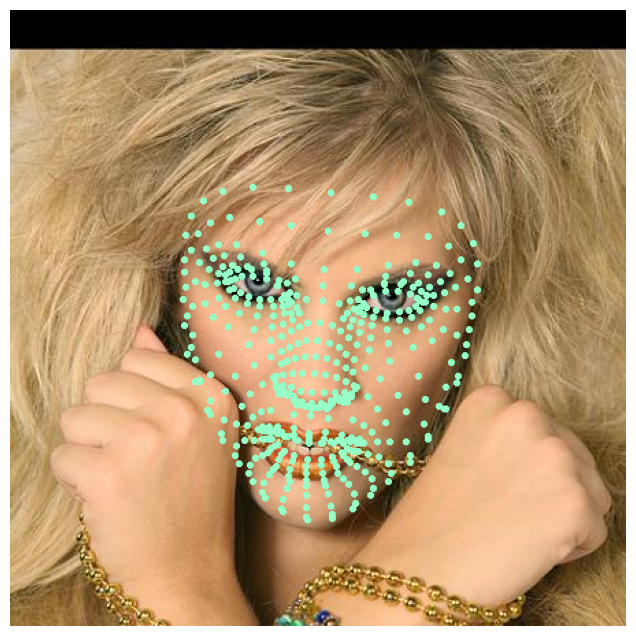

In [38]:
import matplotlib.pyplot as plt
# -----------------------------
# 8️⃣ Draw face landmarks
# -----------------------------
def draw_landmarks(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    with faceModule.FaceMesh(static_image_mode=True) as face_mesh:
        results = face_mesh.process(image_rgb)
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                h, w = image_rgb.shape[:2]
                for lm in face_landmarks.landmark:
                    x = int(lm.x * w)
                    y = int(lm.y * h)
                    cv2.circle(image_rgb, (x, y), 1, (150, 255, 200), 2)
            plt.figure(figsize=(8,8))
            plt.imshow(image_rgb)
            plt.axis('off')
            plt.show()
        else:
            print("No face detected!")

# تجربة
draw_landmarks("/content/aflw2000-3d/AFLW2000/image00002.jpg")

In [22]:
import math
import numpy as np
import cv2

def draw_axis(img, pitch, yaw, roll, tdx=None, tdy=None, size=100):
    pitch = -pitch
    roll = -roll
    yaw = yaw

    h, w = img.shape[:2]

    # لو محددش tdx, tdy، نستخدم الأنف كمركز
    if tdx is None or tdy is None:
        # نفترض إن landmark الأنف هو النقطة رقم 1 في mediapipe
        tdx = int(landmarks.landmark[1].x * w)
        tdy = int(landmarks.landmark[1].y * h)


    # X-axis (red)
    x1 = size*(math.cos(yaw)*math.cos(roll)) + tdx
    y1 = size*(math.cos(pitch)*math.sin(roll)+math.cos(roll)*math.sin(pitch)*math.sin(yaw)) + tdy

    # Y-axis (green)
    x2 = size*(-math.cos(yaw)*math.sin(roll)) + tdx
    y2 = size*(math.cos(pitch)*math.cos(roll)-math.sin(pitch)*math.sin(yaw)*math.sin(roll)) + tdy

    # Z-axis (blue)
    x3 = size*(math.sin(yaw)) + tdx
    y3 = size*(-math.cos(yaw)*math.sin(pitch)) + tdy

    cv2.line(img, (tdx, tdy), (int(x1), int(y1)), (0,0,255), 2)
    cv2.line(img, (tdx, tdy), (int(x2), int(y2)), (0,255,0), 2)
    cv2.line(img, (tdx, tdy), (int(x3), int(y3)), (255,0,0), 2)

    return img

In [39]:
# tdx = int(landmarks.landmark[1].x * w)  # الأنف
# tdy = int(landmarks.landmark[1].y * h)

# image_rgb = draw_axis(image_rgb, pitch, yaw, roll, tdx, tdy)

In [29]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import math

# Face mesh module
faceModule = mp.solutions.face_mesh

# Function to draw axes
def draw_axis(img, pitch, yaw, roll, tdx=None, tdy=None, size=100):
    pitch = -pitch
    roll = -roll
    yaw = yaw

    if tdx is None or tdy is None:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis (red)
    x1 = size*(math.cos(yaw)*math.cos(roll)) + tdx
    y1 = size*(math.cos(pitch)*math.sin(roll)+math.cos(roll)*math.sin(pitch)*math.sin(yaw)) + tdy

    # Y-Axis (green)
    x2 = size*(-math.cos(yaw)*math.sin(roll)) + tdx
    y2 = size*(math.cos(pitch)*math.cos(roll)-math.sin(pitch)*math.sin(yaw)*math.sin(roll)) + tdy

    # Z-Axis (blue)
    x3 = size*(math.sin(yaw)) + tdx
    y3 = size*(-math.cos(yaw)*math.sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1), int(y1)), (0,0,255), 2)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2), int(y2)), (0,255,0), 2)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3), int(y3)), (255,0,0), 2)
    return img

# Function to predict angles and draw landmarks + axes
def predict_and_draw(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    with faceModule.FaceMesh(static_image_mode=True) as face_mesh:
        results = face_mesh.process(image_rgb)

    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0]
        h, w = image_rgb.shape[:2]

        # رسم landmarks على الوجه فقط
        for lm in landmarks.landmark:
            x = int(lm.x * w)
            y = int(lm.y * h)
            cv2.circle(image_rgb, (x, y), 1, (0,255,0), 1)

        # إحداثيات الأنف
        tdx = int(landmarks.landmark[1].x * w)
        tdy = int(landmarks.landmark[1].y * h)

        # تحضير البيانات للموديل
        X_img = preprocess(landmarks).reshape(1,-1)
        pred = multi_output_regressor.predict(X_img)[0]

        yaw, pitch, roll = pred[0], pred[1], pred[2]
        print(f"Predicted Yaw: {yaw:.4f}, Pitch: {pitch:.4f}, Roll: {roll:.4f}")

        # رسم المحاور حوالين الأنف
        image_rgb = draw_axis(image_rgb, pitch, yaw, roll, tdx, tdy)

        plt.figure(figsize=(8,8))
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()
    else:
        print("No face detected!")

Predicted Yaw: -0.3608, Pitch: 0.0610, Roll: 0.0880


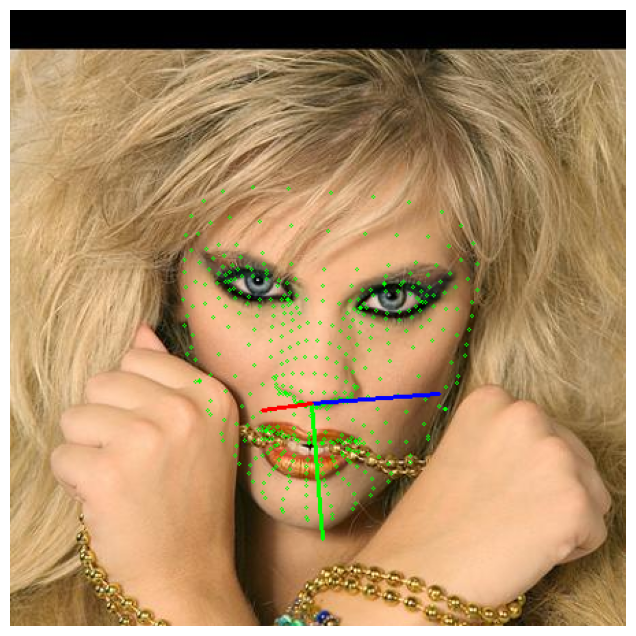

In [32]:
predict_and_draw("/content/aflw2000-3d/AFLW2000/image00002.jpg")